In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# this will have to come from overall function call. It is the difference in local time from PST.
offset_from_pst = 3
cost_mobile_user = .28
cost_desklet_user = .45

In [3]:
nyc = pd.read_csv('gapi_city_data-export-2017-11-30.csv') # read the gapi database
nyc.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
nyc.drop("Organic Searches", axis=1,inplace=True) # Drops Column
nyc = nyc.loc[nyc['City'] == 1023191] # Selects records only NYC

In [4]:
weather = pd.read_csv('open_weather_6cities.csv')  # read the weather database
weather.dropna(axis=1, how='all', inplace=True) # drops all columns where all values are NaN
weather = weather.loc[weather['city_id'] == 5128581] # Selects records only NYC

In [25]:
## check non unique weather rows 
weather_nonunique= weather
a = weather_nonunique['city_id'].astype(str)
b = weather_nonunique['dt'].astype(str)
weather_nonunique['concatenated'] = a+b
# weather_nonunique['concatenated'].value_counts()

In [5]:
##Join tables on Unix Time and return df


# takes a string  in YYYMMDDHH (nyc(Date Hour)) and returns a Unix Time assuming local time zone for input
# this works because (local time on my machine) == (timezone of ga: time{set by ga account preferences}) 
def unixtimestamp(row):
    return int(int(time.mktime(datetime.strptime(row, "%Y%m%d%H").timetuple())))

# creates new column unix_time in nyc using unixtimestamp
nyc['unix_time'] = nyc.apply(lambda row: unixtimestamp(str(row['Date Hour'])), axis=1)

# join nyc to weather on unix_time 
df = nyc.join(weather.set_index('dt'), on='unix_time') 

In [6]:
#TODO: remove the need for this fix by importing fresh city data.

# fix to drop rows where no weather data
df = df.dropna(subset=['temp'])

In [7]:
## Remove nighttime records

## Should we reatin nighttime records in a separate df to see changes there?

# night starts at 1 a.m,ends at 7 a.m. These hard coded values come from client.
night_start = 1
night_end = 6

# Adds hour column with only last two digits from Date Hour
df['Hour'] = df['Date Hour'].transform(str).str.slice(start=8).transform(int)

# function that given target city timezone offset from pst,
#returns start and end hours for the night in terms of pst
def offset_night_times(night_time,pst_offest):
    # if start/end time in pst is premidnight
    if night_time - pst_offest < 0:
        offset_night_time = 24 + night_time - pst_offest
    else:
        offset_night_time = night_time - pst_offest
    return (offset_night_time)

# calls above function and saves start and end of night in local time.
offset_night_start = offset_night_times(night_start,offset_from_pst)
offset_night_end = offset_night_times(night_end,offset_from_pst)

# drops night time values from df. if statement to accommdate possibility that target city night
# start is premidnight local time
def remove_night_hours_df():
    if offset_night_start>offset_night_end:
        df.drop(df[(df.Hour >= 22) | (df.Hour<= 3)].index, inplace=True)
    else:
        df.drop(df[(df.Hour >= 1) & (df.Hour<= 6)].index, inplace=True)

remove_night_hours_df()

assert df['Hour'].nunique() == 18

In [8]:
# Combine desktop and tablet into desklet in Device Category
df.loc[:,('Device Category')] = df.loc[:,('Device Category')].replace(to_replace=['desktop','tablet'],value='desklet')

In [9]:
def extract_month_from_unix(row):
     return int(datetime.fromtimestamp(row).strftime('%m'))
    
df['Month'] = df['unix_time'].apply(extract_month_from_unix)
    
def extract_day_from_unix(row):
    day = (datetime.fromtimestamp(row).strftime('%A'))
    if day == "Saturday" or day == "Sunday":
        return "Weekend"
    else:
        return "Weekday"

In [10]:
high_season = [10,11,12,1,2]
def highlow_season(row):
    if row in high_season:
        return "High Season"
    else:
        return "Low Season"

In [11]:
df['Season'] = df['Month'].apply(highlow_season)

In [12]:
df['weekdayend'] = df['unix_time'].apply(extract_day_from_unix)

In [13]:
def hotcold(row):
    hot = 300
    cold = 274
    if row >= hot:
        return "Hot"
    elif row < cold:
        return "Cold"
    else:
        return "Regular"

In [14]:
df['hotcold'] = df['temp'].apply(hotcold)

In [16]:
df.hotcold.value_counts()

Regular    47500
Cold        5690
Hot         5679
Name: hotcold, dtype: int64

In [36]:
## Map weather_id to main weather categories

def return_first_digit(row):
    return (str(row)[0])

df['weather_category'] = df.loc[:,('weather_id')].apply(return_first_digit)

weather_id_dict = {'2':'2 Thunderstorms','3':'3 Drizzle','5':'5 Rain','6':'6 Snow','7':'7 Atmosphere',
                   '8':'8 Clear','9':'9 Extreme'}

df = df.replace({'weather_category':weather_id_dict}) 

In [37]:
df.head()

City   Date Hour          User Type Device Category  Sessions  \
5903  1023191  2017070207        New Visitor         desklet         2   
5904  1023191  2017070207        New Visitor          mobile         5   
5905  1023191  2017070207        New Visitor         desklet         3   
5906  1023191  2017070207  Returning Visitor          mobile         3   
5907  1023191  2017070207  Returning Visitor         desklet         1   

      Bounces  Users  Transactions  Transaction Revenue  Revenue Per User  \
5903        1      2             0                  0.0               0.0   
5904        2      5             0                  0.0               0.0   
5905        1      3             0                  0.0               0.0   
5906        1      2             0                  0.0               0.0   
5907        0      1             0                  0.0               0.0   

            ...         weather_main  weather_description weather_icon  Hour  \
5903        ...                Clear         Sky is Clear          01d     7   
5904        ...                Clear         Sky is Clear          01d     7   
5905        ...                Clear         Sky is Clear          01d     7   
5906        ...                Clear         Sky is Clear          01d     7   
5907        ...                Clear         Sky is Clear          01d     7   

      Month      Season  weekdayend  hotcold  weather_id_first_digit  \
5903      7  Low Season     Weekend  Regular                       8   
5904      7  Low Season     Weekend  Regular                       8   
5905      7  Low Season     Weekend  Regular                       8   
5906      7  Low Season     Weekend  Regular                       8   
5907      7  Low Season     Weekend  Regular                       8   

      weather_category  
5903           8 Clear  
5904           8 Clear  
5905           8 Clear  
5906           8 Clear  
5907           8 Clear  

[5 rows x 37 columns]

In [318]:
# Select columns 
df2= df[["User Type",'Device Category','Sessions','Transactions', 'Revenue Per User','temp','weather_id']]

In [24]:
(df.tail())

City   Date Hour          User Type Device Category  Sessions  \
5226780  1023191  2017071521        New Visitor         desklet         4   
5226781  1023191  2017071521        New Visitor          mobile        14   
5226782  1023191  2017071521        New Visitor         desklet         1   
5226783  1023191  2017071521  Returning Visitor         desklet         1   
5226784  1023191  2017071521  Returning Visitor          mobile         3   

         Bounces  Users  Transactions  Transaction Revenue  Revenue Per User  \
5226780        0      4             0                  0.0               0.0   
5226781        7     15             0                  0.0               0.0   
5226782        1      1             0                  0.0               0.0   
5226783        1      1             0                  0.0               0.0   
5226784        2      3             0                  0.0               0.0   

          ...     clouds_all  weather_id weather_main  weather_description  \
5226780   ...           20.0       801.0       Clouds           few clouds   
5226781   ...           20.0       801.0       Clouds           few clouds   
5226782   ...           20.0       801.0       Clouds           few clouds   
5226783   ...           20.0       801.0       Clouds           few clouds   
5226784   ...           20.0       801.0       Clouds           few clouds   

         weather_icon  Hour  Month      Season  weekdayend  hotcold  
5226780           02n    21      7  Low Season     Weekend  Regular  
5226781           02n    21      7  Low Season     Weekend  Regular  
5226782           02n    21      7  Low Season     Weekend  Regular  
5226783           02n    21      7  Low Season     Weekend  Regular  
5226784           02n    21      7  Low Season     Weekend  Regular  

[5 rows x 35 columns]

In [321]:
df3 = df2.drop(['Sessions','Transactions'],axis=1)

In [324]:
df4 = df3.pivot_table(index='User Type', columns='weather_id',values='Revenue Per User', aggfunc=np.average)

In [325]:
df4

weather_id         2 Thunderstorms  3 Drizzle    5 Rain    6 Snow  \
User Type                                                           
New Visitor               1.055845   1.295563  0.951011  1.110757   
Returning Visitor         2.739967   3.163282  1.927571  2.399073   

weather_id         7 Atmosphere   8 Clear  
User Type                                  
New Visitor            0.839407  0.908458  
Returning Visitor      1.878682  1.985445

In [326]:
#df4=df4[df4.iloc[-1,:].sort_values(ascending=False).index]


Text(3.5,2.5,'Data without nighttime info')

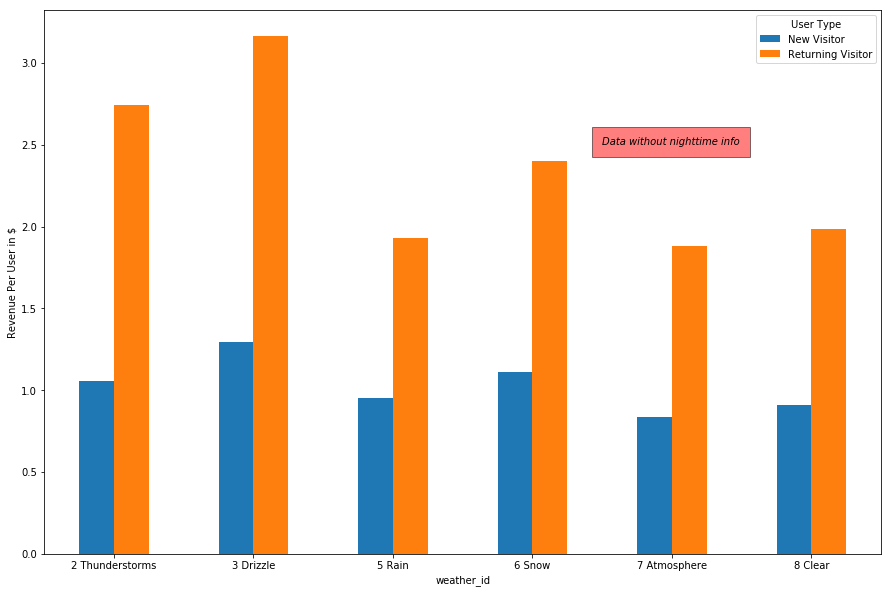

In [327]:
### Average Revenue per customer 
d = df4.transpose().plot.bar()
plt.ylabel('Revenue Per User in $')
plt.xticks(rotation='horizontal')
plt.text(3.5,2.5,  'Data without nighttime info', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

Text(3.5,2.5,'Data with nighttime info')

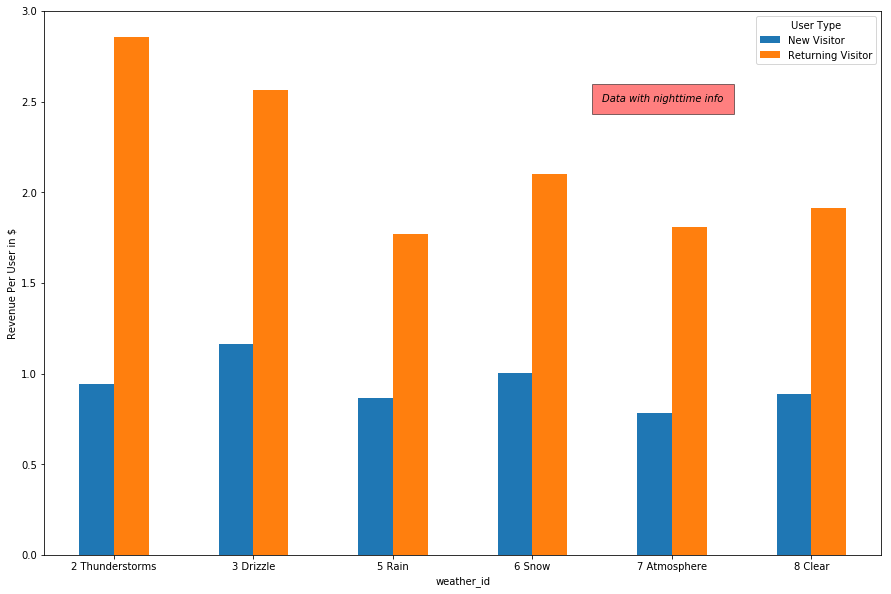

In [310]:
### Average Revenue per customer 
d = df4.transpose().plot.bar()
plt.ylabel('Revenue Per User in $')
plt.xticks(rotation='horizontal')
plt.text(3.5,2.5,  'Data with nighttime info', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

## Weather ID / Revenue per User Graph

#### This graph is for New York City, with Revenue Per User graphed against weather category from Open Weather Maps.  

Catergory 2, which is the umbrella category for thunderstorms, has the highest Ave. Revenue for returning customers.

What is curious is that Drizzle (Cat 3) has higher revenue than rain (Cat 4) I think it would be worth exploring how many of the rain category was light rain, before I stripped the trailing two digits that provides more detail about the kind of rain. It might make sense to move light rain to the drizzle bucket, and put more serious rain events (freezing, heavy, extreme rain) into the thunderstoms bucket, and see if there is further divergence.

There were also sometimes more than one weather classification in the weather table. Should examine those and see if they are expressed in a particular order (I took only the first one) and if we harvest value from both those values.

Once we remedy that and have some data that we think is accurate, we can do a 2 std. dev. above and below average and see if it might make sense to bid more during extreme weather
